In [16]:
import os
import glob
import pandas as pd
import numpy as np
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import joblib
import itertools
from itertools import product
import matplotlib.pyplot as plt

In [17]:
class OptionDataset(Dataset):
    def __init__(self, features, targets):
        """
        Args:
            features (numpy.ndarray): Scaled input features.
            targets (numpy.ndarray): Scaled target values.
        """
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, n_layers=2, hidden_units=128, dropout_rate=0.3):
        """
        Initialize the neural network architecture.

        Parameters:
        - input_dim (int): Number of input features.
        - n_layers (int): Number of hidden layers.
        - hidden_units (int): Number of neurons in each hidden layer.
        - dropout_rate (float): Dropout rate for regularization.
        """
        super(NeuralNet, self).__init__()
        layers = []
        for i in range(n_layers):
            input_dim_layer = input_dim if i == 0 else hidden_units
            layers.append(nn.Linear(input_dim_layer, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_units, 1))  # Output layer for regression
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [19]:
def data_processing(data):
    print("Checking for missing values...")
    missing_values = data.isnull().sum()
    print("Missing values in each column:\n", missing_values)
    data = data.dropna()
    print(f"\nData shape after dropping missing values: {data.shape}\n")

    feature_columns = ['moneyness', 'K', 'T', 'r', 'q', 'v0', 'theta', 'kappa', 'sigma', 'rho']
    target_column = 'call'

    X = data[feature_columns].values
    y = data[target_column].values.reshape(-1, 1)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # train 80%, test 10%, train 10%

    _scaler = RobustScaler() # validation and test sets should both be scaled by the train set's mean & variance
    X_train_scaled = _scaler.fit_transform(X_train)
    X_val_scaled = _scaler.transform(X_train)
    X_test_scaled = _scaler.transform(X_train)

    y_train_scaled = _scaler.fit_transform(y_train)
    y_val_scaled = _scaler.transform(y_train)
    y_test_scaled = _scaler.transform(y_train)

    return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled

In [20]:
# train
def train(model, train_loader, criterion, optimizer, device):
    model.train() 
    total_loss = 0.0
    

    for batch_data, batch_targets in train_loader:
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        batch_data = batch_data.unsqueeze(1)
        batch_targets = batch_targets.unsqueeze(1)

        outputs = model(batch_data)
        loss = criterion(outputs, batch_targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [21]:
# use the test set to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    predictions, true_values = [], []
    total_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            outputs = model(x_test).squeeze()
            y_test = y_test.squeeze()
            predictions.extend(outputs.tolist())
            true_values.extend(y_test.tolist())
            
            loss = criterion(outputs, y_test)
            total_loss += loss.item()
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    avg_loss = total_loss / len(test_loader) 
    
    return mse, mae, r2, avg_loss

In [22]:
def grid_search(hyperparameter_grid, train_dataset, val_dataset, input_dim, device, n_epochs):
    """
    Perform grid search to find the best hyperparameter combination.

    Args:
        hyperparameter_grid (dict): Dictionary of hyperparameter lists to search.
        train_dataset (Dataset): Training dataset.
        val_dataset (Dataset): Validation dataset.
        input_dim (int): Number of input features.
        device (torch.device): Device to use for training and evaluation.
        n_epochs (int): Number of epochs for training each model.

    Returns:
        dict: Best hyperparameters and corresponding performance metrics.
    """
    best_mse = float('inf')
    best_params = None
    best_model = None

    # implementing grid search
    for params in product(*hyperparameter_grid.values()):
        hyperparams = dict(zip(hyperparameter_grid.keys(), params))
        print(f"Training with hyperparameters: {hyperparams}")

        model = NeuralNet(input_dim=input_dim, 
                          n_layers=hyperparams['n_layers'], 
                          hidden_units=hyperparams['hidden_units'], 
                          dropout_rate=hyperparams['dropout_rate']).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), 
                                     lr=hyperparams['learning_rate'], 
                                     weight_decay=hyperparams['weight_decay'])

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)

        # Train the model
        for epoch in range(n_epochs):
            train_loss = train(model, train_loader, criterion, optimizer, device)
            print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {train_loss:.4f}")

        # Evaluate the model
        mse, mae, r2, _ = evaluate_model(model, val_loader, criterion)
        print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")

        # Update best parameters
        if mse < best_mse:
            best_mse = mse
            best_params = hyperparams
            best_model = model

    print(f"\nBest Hyperparameters: {best_params} with MSE: {best_mse}")
    return best_params

In [31]:
def retrain_model(best_params, train_dataset, test_dataset, input_dim, device, n_epochs):
    """
    Retrain the model using the best hyperparameters and evaluate it on the test set.

    Args:
        best_params (dict): Best hyperparameters found during grid search.
        train_dataset (Dataset): Training dataset.
        test_dataset (Dataset): Test dataset.
        input_dim (int): Number of input features.
        device (torch.device): Device to use for training and evaluation.
        n_epochs (int): Number of epochs for training.

    Returns:
        dict: Final model and performance metrics.
    """
    final_model = NeuralNet(input_dim=input_dim, 
                            n_layers=best_params['n_layers'], 
                            hidden_units=best_params['hidden_units'], 
                            dropout_rate=best_params['dropout_rate']).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(final_model.parameters(), 
                                 lr=best_params['learning_rate'], 
                                 weight_decay=best_params['weight_decay'])

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    train_losses = []
    test_losses = []
    epoch_times = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss = train(final_model, train_loader, criterion, optimizer, device)
        mse, mae, r2, test_avg_loss = evaluate_model(final_model, test_loader, criterion)
        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)
        
        train_losses.append(train_loss)
        test_losses.append(test_avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, test Loss: {test_avg_loss:.4f}, Time: {epoch_time:.2f} seconds")
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"Average Epoch Time: {avg_epoch_time:.2f} seconds")
    return {
        "final_model": final_model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "test_mse": mse,
        "test_mae": mae,
        "test_r2": r2,
        "avg_epoch_time": avg_epoch_time
    }


In [36]:
# Plot function
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss Over Time')
    plt.grid(True)
    plt.show()

    file_path = "Training and Test Loss Over Time.png"
    plt.savefig(file_path)
    plt.close()

In [25]:
data = pd.read_csv("E:\ML in Fin Lab\group_proj\cleaned_data.csv")

In [26]:
X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = data_processing(data)

Checking for missing values...
Missing values in each column:
 S0           0
K            0
T            0
r            0
q            0
v0           0
theta        0
kappa        0
sigma        0
rho          0
call         0
moneyness    0
dtype: int64

Data shape after dropping missing values: (109955, 12)



In [27]:
train_dataset = OptionDataset(X_train_scaled, y_train_scaled)
val_dataset = OptionDataset(X_val_scaled, y_val_scaled)
test_dataset = OptionDataset(X_test_scaled, y_test_scaled)

In [12]:
hyperparameter_grid = {
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [256, 512],
    'n_layers': [5],
    'hidden_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.3],
    'weight_decay': [1e-3]
}

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = grid_search(
    hyperparameter_grid=hyperparameter_grid,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    input_dim=10,
    device=device,
    n_epochs=20
)

Training with hyperparameters: {'learning_rate': 0.001, 'batch_size': 256, 'n_layers': 5, 'hidden_units': 64, 'dropout_rate': 0.1, 'weight_decay': 0.001}
Epoch 1/20 - Train Loss: 0.0496
Epoch 2/20 - Train Loss: 0.0104
Epoch 3/20 - Train Loss: 0.0087
Epoch 4/20 - Train Loss: 0.0080
Epoch 5/20 - Train Loss: 0.0076
Epoch 6/20 - Train Loss: 0.0074
Epoch 7/20 - Train Loss: 0.0071
Epoch 8/20 - Train Loss: 0.0071
Epoch 9/20 - Train Loss: 0.0071
Epoch 10/20 - Train Loss: 0.0070
Epoch 11/20 - Train Loss: 0.0070
Epoch 12/20 - Train Loss: 0.0070
Epoch 13/20 - Train Loss: 0.0069
Epoch 14/20 - Train Loss: 0.0069
Epoch 15/20 - Train Loss: 0.0069
Epoch 16/20 - Train Loss: 0.0070
Epoch 17/20 - Train Loss: 0.0069
Epoch 18/20 - Train Loss: 0.0068
Epoch 19/20 - Train Loss: 0.0068
Epoch 20/20 - Train Loss: 0.0068
MSE: 0.0010340599371065607, MAE: 0.023127334592494424, R2: 0.9974732003496727
Training with hyperparameters: {'learning_rate': 0.001, 'batch_size': 256, 'n_layers': 5, 'hidden_units': 64, 'dropou

In [32]:
best_params = {
    'learning_rate': 1e-4,
    'batch_size': 256,
    'n_layers': 5,
    'hidden_units': 256,
    'dropout_rate': 0.1,
    'weight_decay': 1e-3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
retrain_result = retrain_model(
    best_params=best_params, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    input_dim=10, 
    device=device, 
    n_epochs=20)

Epoch 1/20 - Train Loss: 0.0649, test Loss: 0.0026, Time: 4.56 seconds
Epoch 2/20 - Train Loss: 0.0091, test Loss: 0.0015, Time: 4.82 seconds
Epoch 3/20 - Train Loss: 0.0070, test Loss: 0.0011, Time: 5.08 seconds
Epoch 4/20 - Train Loss: 0.0059, test Loss: 0.0010, Time: 5.28 seconds
Epoch 5/20 - Train Loss: 0.0052, test Loss: 0.0008, Time: 6.38 seconds
Epoch 6/20 - Train Loss: 0.0048, test Loss: 0.0008, Time: 10.52 seconds
Epoch 7/20 - Train Loss: 0.0044, test Loss: 0.0008, Time: 14.91 seconds
Epoch 8/20 - Train Loss: 0.0042, test Loss: 0.0007, Time: 22.51 seconds
Epoch 9/20 - Train Loss: 0.0039, test Loss: 0.0007, Time: 28.45 seconds
Epoch 10/20 - Train Loss: 0.0038, test Loss: 0.0006, Time: 35.28 seconds
Epoch 11/20 - Train Loss: 0.0036, test Loss: 0.0007, Time: 42.45 seconds
Epoch 12/20 - Train Loss: 0.0036, test Loss: 0.0007, Time: 52.15 seconds
Epoch 13/20 - Train Loss: 0.0034, test Loss: 0.0010, Time: 57.08 seconds
Epoch 14/20 - Train Loss: 0.0034, test Loss: 0.0006, Time: 57.68 

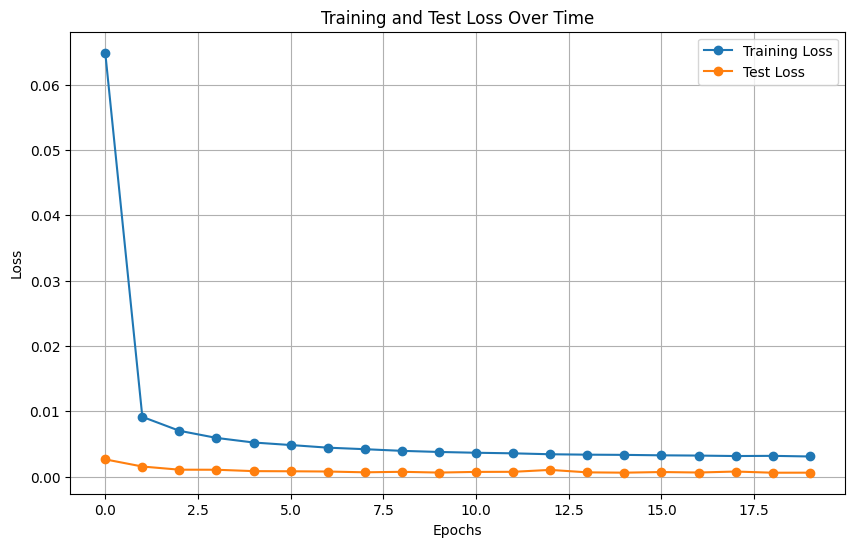

In [37]:
plot_loss(retrain_result["train_losses"], retrain_result["test_losses"])

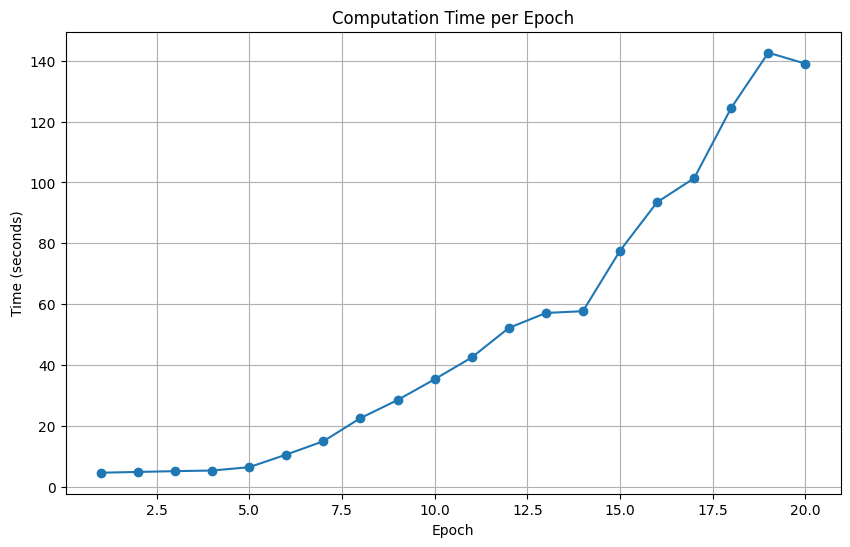

In [38]:
epochs = list(range(1, 21))
times = [
    4.56, 4.82, 5.08, 5.28, 6.38, 10.52, 14.91, 22.51, 28.45, 35.28,
    42.45, 52.15, 57.08, 57.68, 77.56, 93.49, 101.41, 124.54, 142.65, 139.06
]

# Plot the time per epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, times, marker='o')
plt.title("Computation Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

file_path = "computation_time_per_epoch.png"
plt.savefig(file_path)
plt.close()

In [39]:
retrain_result

{'final_model': NeuralNet(
   (network): Sequential(
     (0): Linear(in_features=10, out_features=256, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.1, inplace=False)
     (3): Linear(in_features=256, out_features=256, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.1, inplace=False)
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): ReLU()
     (8): Dropout(p=0.1, inplace=False)
     (9): Linear(in_features=256, out_features=256, bias=True)
     (10): ReLU()
     (11): Dropout(p=0.1, inplace=False)
     (12): Linear(in_features=256, out_features=256, bias=True)
     (13): ReLU()
     (14): Dropout(p=0.1, inplace=False)
     (15): Linear(in_features=256, out_features=1, bias=True)
   )
 ),
 'train_losses': [0.06491168029335609,
  0.009144577582171836,
  0.007011518502326379,
  0.005919921440667971,
  0.005216382986048323,
  0.004830018404687127,
  0.004426883268955185,
  0.004192527724013036,
  0.00393974733590365,
  0.0037687781509174426,
  0.0036474022842

In [98]:
import logging
logger = logging.getLogger()
# Use Reduce dataset to do feature importance analysis
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
X_test_subset = X_test_scaled[np.random.choice(X_test_scaled.shape[0], 100, replace=False)]

batch_size = 10
num_batches = len(X_test_subset) // batch_size

# Use GradientExplainer for speed
explainer = shap.GradientExplainer(
    retrain_result["final_model"], 
    torch.tensor(background, dtype=torch.float32).to(device)
)

shap_values = []
for batch_idx in range(num_batches):
    logger.info(f"Processing batch {batch_idx + 1}/{num_batches}...")
    batch = X_test_subset[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    shap_value = explainer.shap_values(
        torch.tensor(batch, dtype=torch.float32).to(device)
    )
    shap_values.append(shap_value)

logger.info("All batches processed.")

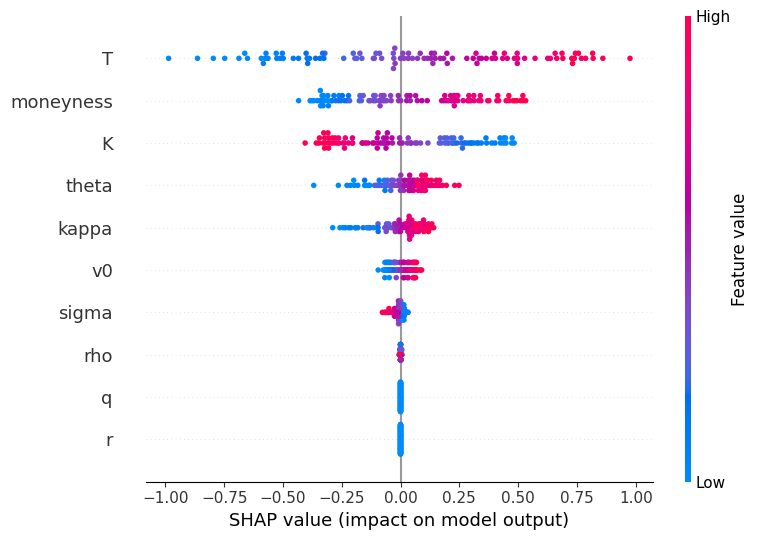

In [99]:
feature_names = ['moneyness', 'K', 'T', 'r', 'q', 'v0', 'theta', 'kappa', 'sigma', 'rho']
shap_values = np.concatenate(shap_values, axis=0)
shap.summary_plot(
    shap_values, 
    X_test_subset, 
    feature_names=feature_names, 
    plot_type='dot'  # Optional: Specify plot type
)

# 
Correlation Analysis Between Features

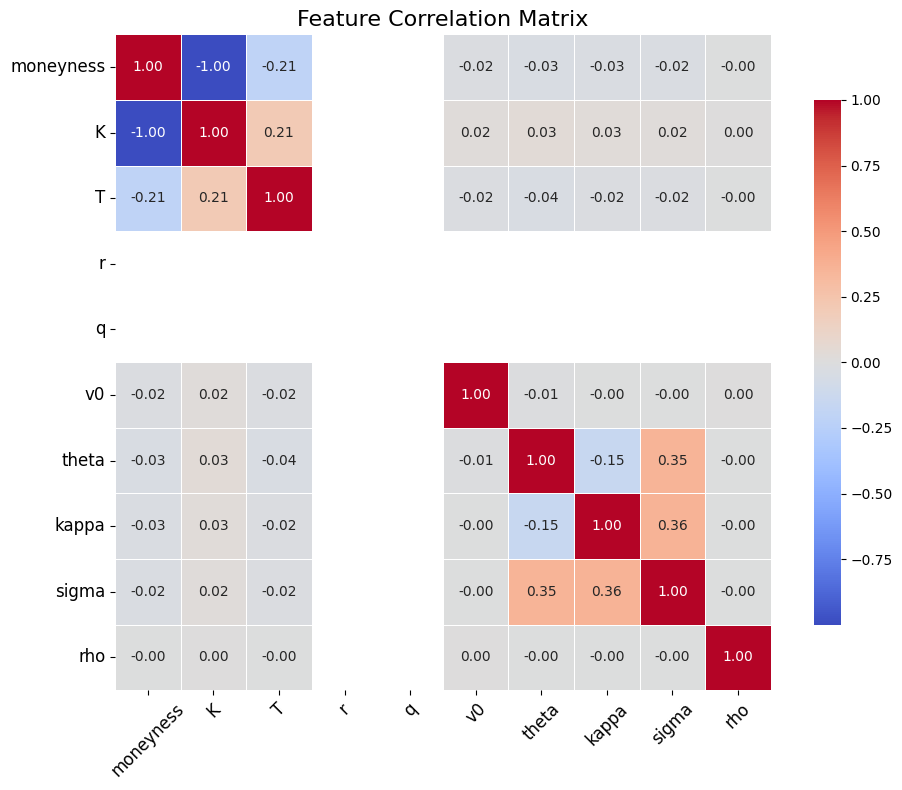

In [79]:
import seaborn as sns

correlation_matrix = pd.DataFrame(X_train_scaled, columns=feature_names).corr()
plt.figure(figsize=(10, 8))

# Create a heatmap with better styling
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    square=True
)

# Add titles and labels
plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()